# Download Data 

In [1]:
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
!unzip -qq Flickr8k_Dataset.zip
!unzip -qq Flickr8k_text.zip
!rm Flickr8k_Dataset.zip Flickr8k_text.zip

# Import Libraries and Tools

In [2]:
import tensorflow as tf


import numpy as np
from PIL import Image
import os
import string
from pickle import dump
from pickle import load
from keras.applications.xception import Xception #to get pre-trained model Xception
from keras.applications.xception import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.text import Tokenizer #for text tokenization
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers.merge import add
from keras.models import Model, load_model
from keras.layers import Input, Dense#Keras to build our CNN and LSTM
from keras.layers import LSTM, Embedding, Dropout
from tqdm import tqdm_notebook as tqdm #to check loop progress
tqdm().pandas()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0it [00:00, ?it/s]

In [3]:
#!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
#!unzip -qq Flickr8k_Dataset.zip
!unzip -qq Flickr8k_text.zip
#!rm Flickr8k_Dataset.zip Flickr8k_text.zip

replace CrowdFlowerAnnotations.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# Cleaning Captions

In [4]:

# Path to the images
IMAGES_PATH = "Flicker8k_Dataset"


In [5]:

def load_captions_data(filename):
    """Loads captions (text) data and maps them to corresponding images.

    Args:
        filename: Path to the text file containing caption data.

    Returns:
        caption_mapping: Dictionary mapping image names and the corresponding captions
        text_data: List containing all the available captions
    """
    SEQ_LENGTH = 25
    with open(filename) as caption_file:
        caption_data = caption_file.readlines()
        caption_mapping = {}
        text_data = []
        images_to_skip = set()

        for line in caption_data:
            line = line.rstrip("\n")
            # Image name and captions are separated using a tab
            img_name, caption = line.split("\t")

            # Each image is repeated five times for the five different captions.
            # Each image name has a suffix `#(caption_number)`
            img_name = img_name.split("#")[0]
            img_name = os.path.join(IMAGES_PATH, img_name.strip())

            # We will remove caption that are either too short to too long
            tokens = caption.strip().split()

            if len(tokens) < 5 or len(tokens) > SEQ_LENGTH:
                images_to_skip.add(img_name)
                continue

            if img_name.endswith("jpg") and img_name not in images_to_skip:
                # We will add a start and an end token to each caption
                caption = caption.strip() 
                
                text_data.append(caption)

                if img_name in caption_mapping:
                    caption_mapping[img_name].append(caption)
                else:
                    caption_mapping[img_name] = [caption]

        for img_name in images_to_skip:
            if img_name in caption_mapping:
                del caption_mapping[img_name]

        return caption_mapping, text_data


def train_val_split(caption_data, train_size=0.8, shuffle=True):
    """Split the captioning dataset into train and validation sets.

    Args:
        caption_data (dict): Dictionary containing the mapped caption data
        train_size (float): Fraction of all the full dataset to use as training data
        shuffle (bool): Whether to shuffle the dataset before splitting

    Returns:
        Traning and validation datasets as two separated dicts
    """

    # 1. Get the list of all image names
    all_images = list(caption_data.keys())

    # 2. Shuffle if necessary
    if shuffle:
        np.random.shuffle(all_images)

    # 3. Split into training and validation sets
    train_size = int(len(caption_data) * train_size)

    training_data = {
        img_name: caption_data[img_name] for img_name in all_images[:train_size]
    }
    validation_data = {
        img_name: caption_data[img_name] for img_name in all_images[train_size:]
    }

    # 4. Return the splits
    return training_data, validation_data


# Load the dataset
captions_mapping, text_data = load_captions_data("Flickr8k.token.txt")

In [6]:
# Load the document file into memory
def load_fp(filename):
  # Open file to read
  file = open(filename, 'r')
  text = file.read()
  file.close()
  return text


# get all images with their captions
def img_capt(filename):
  file = load_fp(filename)
  captions = file.split('n')
  descriptions ={}
  for caption in captions[:-1]:
    print(caption.split('t'))
    img, caption = caption.split('t')
    if img[:-2] not in descriptions:
      descriptions[img[:-2]] = [ caption ]
    else:
      descriptions[img[:-2]].append(caption)

  return descriptions


#Data cleaning function will convert all upper case alphabets to lowercase, removing punctuations and words containing numbers

def txt_clean(captions):
  table = str.maketrans('','',string.punctuation)
  for img,caps in captions.items():
    for i,img_caption in enumerate(caps):
           img_caption.replace("-"," ")
           descp = img_caption.split()
          #uppercase to lowercase
           descp = [wrd.lower() for wrd in descp]
          #remove punctuation from each token
           descp = [wrd.translate(table) for wrd in descp]
          #remove hanging 's and a
           descp = [wrd for wrd in descp if(len(wrd)>1)]
          #remove words containing numbers with them
           descp = [wrd for wrd in descp if(wrd.isalpha())]
          #converting back to string
           img_caption = ' '.join(descp)
           captions[img][i]= img_caption
  return captions

def start_end(captions):
  table = str.maketrans('','',string.punctuation)
  for img,caps in captions.items():
    for i,img_caption in enumerate(caps):
           img_caption = '<start> ' + img_caption + ' <end>'
           captions[img][i]= img_caption
  return captions


def txt_vocab(descriptions):
  # To build vocab of all unique words
  vocab = set()
  for key in descriptions.keys():
       [vocab.update(d.split()) for d in descriptions[key]]
  return vocab

#To save all descriptions in one file
def save_descriptions(descriptions, filename):
  lines = list()
  for key, desc_list in descriptions.items():
    for desc in desc_list:
      lines.append(key + 't' + desc )

  data = "n".join(lines)
  file = open(filename,"w")
  file.write(data)
  file.close()


In [7]:
print("Length of descriptions =" ,len(captions_mapping))
#cleaning the descriptions
clean_descriptions = txt_clean(captions_mapping)
#to build vocabulary
clean_descriptions = start_end(clean_descriptions)
vocabulary = txt_vocab(clean_descriptions)
print("Length of vocabulary = ", len(vocabulary))

train_data, valid_data = train_val_split(clean_descriptions)
print("Number of training samples: ", len(train_data))
print("Number of validation samples: ", len(valid_data))

Length of descriptions = 7643
Length of vocabulary =  8507
Number of training samples:  6114
Number of validation samples:  1529


In [8]:
save_descriptions(clean_descriptions, "descriptions_clean1.txt")

# Loading Saved Features of Train image data

Run this only if already saved

In [9]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [10]:
features = load(open("/content/gdrive/MyDrive/Image Captioning/features.p","rb"))
type(features)

dict

# Feature extraction if not extracted already

If not extracted:

In [10]:
model = Xception( include_top=False,pooling='avg')

83697664/83683744 [==============================] - 0s 0us/step


In [14]:
def extract_features(directory):
  model = Xception( include_top=False, pooling='avg' )
  features = {}
  for pic in tqdm(os.listdir(IMAGES_PATH)):
           file = IMAGES_PATH + "/" + pic
           image = Image.open(file)
           image = image.resize((299,299))
           image = np.expand_dims(image, axis=0)
          #image = preprocess_input(image)
           image = image/127.5
           image = image - 1.0
           feature = model.predict(image)
           features[pic] = feature
  return features

#2048 feature vector
features = extract_features('/content/Flicker8k_Dataset')
# dump(features, open("/content/drive/MyDrive/features.p","wb"))
#to directly load the features from the pickle file.
# features = load(open("/content/drive/MyDrive/features.p","rb"))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/8091 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

# Building Vocabulary

In [11]:
train_descriptions = train_data
descriptions = captions_mapping
Vocab_size = 10000


#convert dictionary to clear list of descriptions
def dict_to_list(descriptions):
  all_desc = []
  for key in descriptions.keys():
    for d in descriptions[key]:
      all_desc.append(d) 
  return all_desc
#creating tokenizer class
#this will vectorise text corpus
#each integer will represent token in dictionary

from keras.preprocessing.text import Tokenizer
def create_tokenizer(descriptions):
   desc_list = dict_to_list(descriptions)
   tokenizer = Tokenizer()
   tokenizer.fit_on_texts(desc_list)
   return tokenizer

# give each word an index, and store that into tokenizer.p pickle file
tokenizer = create_tokenizer(descriptions)
dump(tokenizer, open('/content/gdrive/MyDrive/Image Captioning/tokenizer.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
Vocab_size #The size of our vocabulary is 7577 words.
#calculate maximum length of descriptions to decide the model structure parameters.
def max_length(descriptions):
   desc_list = dict_to_list(descriptions)
   return max(len(d.split()) for d in desc_list)
Max_length = max_length(descriptions)
Max_length #Max_length of description is 32

26

# Build and Train Model

In [12]:
#data generator, used by model.fit_generator()
def data_generator(descriptions, features, tokenizer, max_length):
  while 1:
    for key, description_list in descriptions.items():
          #retrieve photo features
           feature = features[key[18:]][0]
           inp_image, inp_seq, op_word = create_sequences(tokenizer, max_length, description_list, feature)
           yield [[inp_image, inp_seq], op_word]

def create_sequences(tokenizer, max_length, desc_list, feature):
  x_1, x_2, y = list(), list(), list()
  # move through each description for the image
  for desc in desc_list:
      # encode the sequence
    seq = tokenizer.texts_to_sequences([desc])[0]
      # divide one sequence into various X,y pairs
  for i in range(1, len(seq)):
          # divide into input and output pair
      in_seq, out_seq = seq[:i], seq[i]
          # pad input sequence
     
      in_seq = tf.keras.preprocessing.sequence.pad_sequences([in_seq], maxlen=Max_length)[0]
          # encode output sequence
      out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
          # store
      x_1.append(feature)
      x_2.append(in_seq)
      y.append(out_seq)

  return np.array(x_1), np.array(x_2), np.array(y)

#To check the shape of the input and output for your model
[a,b],c = next(data_generator(train_descriptions, features, tokenizer, max_length))
a.shape, b.shape, c.shape
#((47, 2048), (47, 32), (47, 7577))

((8, 2048), (8, 26), (8, 8506))

In [13]:
from tensorflow.keras.utils import plot_model
# define the captioning model
def define_model(vocab_size, max_length):
  # features from the CNN model compressed from 2048 to 256 nodes
   inputs1 = Input(shape=(2048,))
   fe1 = Dropout(0.5)(inputs1)
   fe2 = Dense(256, activation='relu')(fe1)
  # LSTM sequence model
   inputs2 = Input(shape=(max_length,))
   se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
   se2 = Dropout(0.5)(se1)
   se3 = LSTM(256)(se2)
  # Merging both models
   decoder1 = add([fe2, se3])
   decoder2 = Dense(256, activation='relu')(decoder1)
   outputs = Dense(vocab_size, activation='softmax')(decoder2)
  # merge it [image, seq] [word]
   model = Model(inputs=[inputs1, inputs2], outputs=outputs)
   model.compile(loss='categorical_crossentropy', optimizer='adam')
  # summarize model
   print(model.summary())
   plot_model(model, to_file='model.png', show_shapes=True)
   return model

In [14]:
# train our model
#print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', Max_length)
model = define_model(vocab_size, Max_length)
epochs = 30
steps = len(train_descriptions)
# creating a directory named models to save our models
#os.mkdir("models")
for i in range(epochs):
   generator = data_generator(train_descriptions, features, tokenizer, Max_length)
   model.fit_generator(generator, epochs=1, steps_per_epoch= steps, verbose=1)
   model.save("/content/gdrive/MyDrive/Image Captioning/model_" + str(i) + ".h5")

Descriptions: train= 6114
Photos: train= 8091
Vocabulary Size: 8506
Description Length:  26
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 26)]         0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 26, 256)      2177536     ['input_2[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_1[0][0]']                
  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


6114/6114 [==============================] - 517s 85ms/step - loss: 2.4435


In [15]:
dump(train_descriptions, open("/content/gdrive/MyDrive/Image Captioning/train_data.p","wb"))

In [16]:
dump(valid_data, open("/content/gdrive/MyDrive/Image Captioning/valid_data.p","wb"))

# DEMO:

Load Saved Tokenizer, Xception Model and the trained Custom Model.

In [17]:
from tensorflow.python.eager.context import in_eager_mode
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import argparse
from pickle import load
from keras.applications.xception import Xception
from keras.models import Model, load_model
from keras.applications.xception import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.text import Tokenizer #for text tokenization
from keras.preprocessing.sequence import pad_sequences


def extract_features(filename, model):

  #image = Image.open(filename)
      
  #image = image.resize((299,299))
  #image = np.array(image)
  image = Image.open(filename)
  image = image.resize((299,299))
  image = np.expand_dims(image, axis=0)
          #image = preprocess_input(image)
  image = image/127.5
  image = image - 1.0
  print(np.shape(image))
  feature = model.predict(image)

  print(np.shape(feature))

  return feature

  # for 4 channels images, we need to convert them into 3 channels
''' if image.shape[2] == 4:
      print("here1")
      image = image[..., :3]
      image = np.expand_dims(image, axis=0)
      image = image/127.5
      image = image - 1.0
      print(np.shape(image))
      feature = model.predict(image)
  else:
      print("here2")

      image = image/127.5
      image = image - 1.0
      feature = model.predict(image.reshape(-1,299,299,3)) 
      
'''


def word_for_id(integer, tokenizer):
  for word, index in tokenizer.word_index.items():
      if index == integer:
        return word
  return None


def generate_desc(model, tokenizer, photo, max_length):
  in_text = 'start'
  for i in range(max_length):
       sequence = tokenizer.texts_to_sequences([in_text])[0]
       sequence = pad_sequences([sequence], maxlen=max_length)
      
       pred = model.predict([photo,sequence], verbose=0)
       pred = np.argmax(pred)
       word = word_for_id(pred, tokenizer)
       if word is ".":
           break
       in_text += ' ' + word
       if word == 'end':
           break
  
  decoded_caption = in_text.replace("start ", "")
  decoded_caption = decoded_caption.replace(" end", "").strip()
  return decoded_caption


In [18]:
max_length = 26
tokenizer = load(open("/content/gdrive/MyDrive/Image Captioning/tokenizer.p","rb"))
model = load_model('/content/gdrive/MyDrive/Image Captioning/model_29.h5')
xception_model1 = Xception(include_top=False,pooling='avg')

83697664/83683744 [==============================] - 1s 0us/step


In [19]:
def predict_caption(img_path):
    photo = extract_features(img_path, xception_model1)

    photo = photo.reshape(1,2048)
    print(sum(photo[0]))
    img = Image.open(img_path)
    description = generate_desc(model, tokenizer,photo, max_length)
    print(description)
    plt.imshow(img)

#### Enter image path

(1, 299, 299, 3)
(1, 2048)
262.2798137884738
262.2797478213313
the dog is running through the water


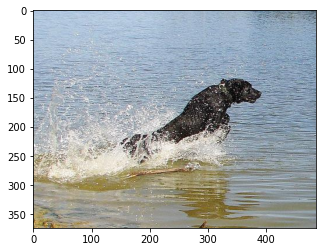

In [20]:
img_path = 'Flicker8k_Dataset/1731546544_9fbf14617b.jpg'

photo = extract_features(img_path, xception_model1)
photo = photo.reshape(1,2048)
print(sum(photo[0]))
img = Image.open(img_path)
description = generate_desc(model, tokenizer,features["1731546544_9fbf14617b.jpg"], max_length)
print(sum(features["1731546544_9fbf14617b.jpg"][0]))

print(description)
plt.imshow(img)

(1, 299, 299, 3)
(1, 2048)
386.6919389407576
the man is standing on the floor


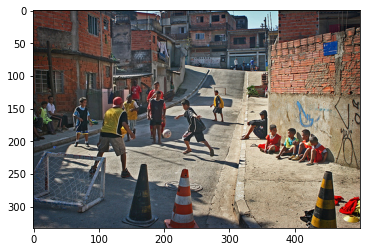

In [21]:
predict_caption("Flicker8k_Dataset/3349955993_a04aea97d8.jpg")

{'2550109269_bc4262bd27.jpg': array([[0.02613091, 0.27568024, 0.12429283, ..., 0.01603137, 0.        ,
         0.        ]], dtype=float32),
 '354642192_3b7666a2dd.jpg': array([[0.16878225, 0.15032153, 0.00636726, ..., 0.07407355, 0.05601262,
         0.2678035 ]], dtype=float32),
 '3421177332_a05741cfa4.jpg': array([[0.04424749, 0.01490649, 0.22183575, ..., 0.4525187 , 0.20109546,
         0.01749899]], dtype=float32),
 '3724150944_fc62e8d5e0.jpg': array([[0.06702102, 0.04951208, 0.03120626, ..., 0.33503175, 0.00885316,
         0.00255381]], dtype=float32),
 '3424424006_98f9d1921c.jpg': array([[0.01481787, 0.0238625 , 0.17831235, ..., 0.        , 0.23811993,
         0.33718407]], dtype=float32),
 '515755283_8f890b3207.jpg': array([[0.05329822, 0.47424638, 0.17065783, ..., 0.00768283, 0.01028778,
         0.        ]], dtype=float32),
 '3128856481_86e5df4160.jpg': array([[0.4525869 , 0.        , 0.00254753, ..., 0.32004502, 0.16449739,
         0.00139002]], dtype=float32),
 '328981

In [ ]:
train_data.keys()


dict_keys(['Flicker8k_Dataset/3611672054_45edd3e08f.jpg', 'Flicker8k_Dataset/2635023078_6dae04758f.jpg', 'Flicker8k_Dataset/757133580_ba974ef649.jpg', 'Flicker8k_Dataset/2515247156_c1b759fc33.jpg', 'Flicker8k_Dataset/1389323170_d1c81d6b51.jpg', 'Flicker8k_Dataset/2151300603_248a9fe715.jpg', 'Flicker8k_Dataset/3562282690_cd2a95fe9e.jpg', 'Flicker8k_Dataset/191003285_edd8d0cf58.jpg', 'Flicker8k_Dataset/2663248626_f000f2661d.jpg', 'Flicker8k_Dataset/429205889_ff5a006311.jpg', 'Flicker8k_Dataset/1798215547_ef7ad95be8.jpg', 'Flicker8k_Dataset/3131107810_7e9b96cddc.jpg', 'Flicker8k_Dataset/1394368714_3bc7c19969.jpg', 'Flicker8k_Dataset/405331006_4e94e07698.jpg', 'Flicker8k_Dataset/544576742_283b65fa0d.jpg', 'Flicker8k_Dataset/2967549094_d32422eb01.jpg', 'Flicker8k_Dataset/3091916691_b1c96669c6.jpg', 'Flicker8k_Dataset/3595412126_4020d4643b.jpg', 'Flicker8k_Dataset/1594038143_57f299aa8a.jpg', 'Flicker8k_Dataset/3490874218_babb404b39.jpg', 'Flicker8k_Dataset/2915183095_4ed4aa4f37.jpg', 'Flicke

In [22]:
train_data['Flicker8k_Dataset/2915183095_4ed4aa4f37.jpg']

['<start> people playing basketball ball in air <end>',
 '<start> group of boys play basketball outside of brown building <end>',
 '<start> three people stand on basketball court as ball flies through the air <end>',
 '<start> three teen boys playing basketball outside <end>',
 '<start> three teens watching basketball in the air <end>']